# Why some resturant are successful

## Introduction

Since everyone loves food (presumably), the ultimate end goal of this homework will determine the success of restaurant. there are various of restaurants in the world but some are successful and others are not. We want to use the data from yelp to analysis the insight of what is the definition of the successful restaurant. 

We assume that the score of a restaurant on Yelp and reflect the degree of success of this restaurant. We want to use the info from the restaurants such as its location, menu, environment, and kinds of attributes from those websites and analyze the factors which contribute to the success of a restaurant. Then we could try to use this function generated to evaluate the future business of a new restaurant and try to give some advice on how to make them become better.


### Overall Solutions

To tell why some restaurants are successful, we have some steps to do.

First is to give the definition of the ‘success’ of certain restaurant. We assume that the score could reflect the degree of success but the detail of how to reflect needs to be determined by doing some analytics. We need to use the distribution of score to decide which score is the threshold of successful restaurants. 

Second, when we have decided how to reflect the success degree by the score, then we can divide the restaurant data into two parts and dig into the details. This is the main part of the project that needs to be dealt with because there are many things to be decided here. Like which attributes may contribute to the success of restaurant? How to measure these attributes like location? What the granularity should be picked for these attributes?

Last but not least, we need to visualize the result make some conclusion based on this.


## Definition of Success

The first part of out project is to get the definition of success. To get this done, we must first scrap the data from Yelp using the techs we learned before and do some simple analytic based on this data.

Here are some basic libairies that will be used during this project.


In [35]:
# setup library imports
import requests
from bs4 import BeautifulSoup
import collections
import numpy as np
# import yelp client library
from yelp.client import Client
from yelp.oauth1_authenticator import Oauth1Authenticator
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn # or alternatively plt.style.use('ggplot') for a similar look

matplotlib.rc("figure", figsize=(4,3))
matplotlib.rc("axes", labelsize=8, titlesize=8)
matplotlib.rc("xtick", labelsize=7)
matplotlib.rc("ytick", labelsize=7)
matplotlib.rc("legend", fontsize=7)
matplotlib.rc("font", size=7)

---

### Fetch Data

The first step of data science project is to get the data for later science use. Here, we use the both Yelp API and scraper to help get all the data needed for our project. 

Yelp API is used for get the restaurant attributes data. It will return all the things in Json format which has very food format and detailed and correct information. Scraper is used for getting the review and rating score of certain restaurant by parsing the webpage. Scraper could get all the data which could be accessed by user. But the correctness could be lower beacause it is parsed by us.

Before we used Yelp API, we must first autheticate with the authentication API of Yelp. We could use the authenticate function here to authenticate with the Yelp.


In [2]:
def authenticate(config_filepath):
    """
    Create an authenticated yelp-python client.

    Args:
        config_filepath (string): relative path (from this file) to a file with your Yelp credentials

    Returns:
        client (yelp.client.Client): authenticated instance of a yelp.Client
    """
    import yelp_auth as ya
    auth = Oauth1Authenticator(
        consumer_key=ya.CONSUMER_KEY,
        consumer_secret=ya.CONSUMER_SECRET,
        token=ya.TOKEN,
        token_secret=ya.TOKEN_SECRET
    )
    return Client(auth)
client = authenticate('yelp_auth.py')


###  Using yelp API - Aquire all of the restaurants in Mountain View city

After we authenticate with Yelp, then we can use the Yelp API to get data that may be used in the analytics. The input object will be structured as the [sample](https://www.yelp.com/developers/documentation/v2/search_api#sampleResponse) on the Yelp API page.

Here, we want to make analytics on all the restaurants in one city. In our project, we want to use the city 'Mountian View, CA' as the target city. And during the implementation, we found that if we fetch the data with city as parameter, we won't get correct data because there are too many cities with the same name in United States. So we use the zip code as the input parameter. In this way, we could get the data from correct city.


In [4]:
from geosearch_py import GeoSearch
import numpy as np
import itertools
chunk_size = 4

def authenticate_geoclient(config_path):
    with open(config_path) as f:
        key = f.read().strip()
    return GeoSearch(key)

def get_geo_bbox(client, location):
    bbox = client.geo_bounds(location)
    lats = np.linspace(*sorted([bbox['northeast']['lat'], bbox['southwest']['lat']]), num=chunk_size)
    lons = np.linspace(*sorted([bbox['northeast']['lng'], bbox['southwest']['lng']]), num=chunk_size)
    return [(lats[i+1], lons[j], lats[i], lons[j+1]) for i in range(chunk_size-1) for j in range(chunk_size-1)]

def get_restaurants_in_city(client, query):
    """
    Retrieve ALL the restaurants on Yelp for a given query.

    Args:
        query (string): Search term
 Returns:
        results (list): list of yelp.obj.business.Business objects
    """
    bbox = get_geo_bbox(authenticate_geoclient('geoclient'), query)
    size = 20
    ret = []
    for box in bbox:
        param = {'term':'food', 'limit':size, 'offset': 0}
        res = client.search_by_bounding_box(*box, **param)
        all_rest = res.businesses
        total = res.total - size
        offset = size
        while total > 0:
            time.sleep(0.2)
            param['offset'] = offset
            try:
                businesses = client.search(query, **param).businesses
            except:
                if len(all_rest) * 1.0 / total > 0.5:
                    return all_rest
                return all_rest
            all_rest += businesses
            total -= len(businesses)
            offset += size
        ret += all_rest
    return ret

data = []
data = get_restaurants_in_city(client, 'Mountain View, CA')
with open('data.data', 'wb') as f:
    pickle.dump(data, f)

### Parse web pages - get more data like reviews and prices

After we get the distribution of rating, in other words, the definition of success. Then we can deal with the source data. The first data we want to analyze is the review data. Review data can only be fetched by parsing the page.

We want to implement a function with such input and output. The input is the url of restaurant and we want the get the return as a json with contains some infomation like review_id, text which is good at future analysis.

```python
# Input:
    restuanrant url
# Output

[{
    'review_id': '12345'
    'user_id': '6789'
    'rating': 4.7
    'date': '2016-01-23'
    'text': "Wonderful!"
},{}...]
```



### Extract all reviews for each restuarant
After we parse the page, then we can try to get the yelp reivews for this restaurant. This is the same as we did in homework. To make notebook more readable we extract this part of code out as helper functions.
### Extract price range for each restuarant
Since the API does not provide this info, we need to parse the web page which is similar as getting reviews.

In [1]:
from crawl_web_page import extract_all_reviews, extract_all_prices
urls = {f.id: f.url for f in data}
extract_all_reviews(urls)
extract_all_prices(urls)

---
# Exploring data

For convience we dump all the data into pickle data files. To load them:
https://drive.google.com/open?id=0B3Df7jt5KWPcME1UTEl3c0Z4RnM

In [19]:
with open('data.data') as f:
    restuarant = pickle.load(f)
with open('reviews.data') as f:
    res_reviews = pickle.load(f)
with open('price.data') as f:
    res_price = pickle.load(f)
print restuarant[0]

### Rating distribution
Now, we have got all the data of restaurants located in Mountain View, CA. Then we want to get the distribution of ratings of these restaurants. Before we do it, we could first draw the distribution of ratings. 

From the image, we could see the distribution may apply to a normal distribution. We define above 4.0 as the threshold as a nice restuarant and below 3.0 as a bad one.

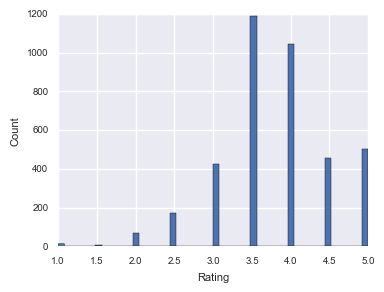

In [43]:
ratings = [d.rating for d in restuarant]
plt.hist(ratings, bins=50)
plt.xlabel("Rating")
plt.ylabel("Count")

Counter({2: 721, 1: 627, 0: 280, 3: 55, 4: 8})


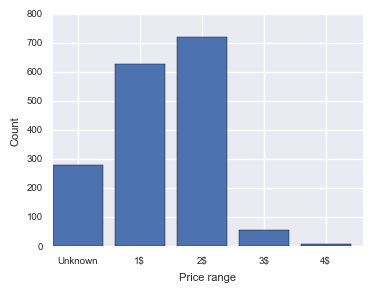

In [52]:
counts = collections.Counter([len(d) for d in res_price.values()])
print counts
plt.bar(range(len(counts)), counts.values())
plt.xticks(np.arange(len(counts))+0.4, ['Unknown','1$','2$','3$','4$'])
plt.ylabel("Count")
plt.xlabel("Price range")


## How to improve my restaurant - Extracting topics from reviews

When you runs a bussiness, especially a restaurant, you gather tons of reviews from your customers. How can you know what you can improve your business? Using topic modeling, we can extract the topics from both the good reviews and the bad reviews. From the good reviews, you can know what your customers like about your restaurant. From the bad reviews, you can know what your customers dislike about your restaurant. 

In this section, we will illustrate how to do topic modeling using a technique called non-negative matrix factorization (NMF) that strongly resembles Latent Dirichlet Allocation (LDA). As LDA is a probabilistic model we often use capable of expressing uncertainty about the placement of topics across different texts and the assignment of the words to the topics, NMF is different. It goes to a single representation of the corpus. So NMF is often characterized as a machine learning algorithm. The algorithm will be shown as below.

In [1]:
import numpy as np
import sklearn.feature_extraction.text as text
from sklearn import decomposition

In [5]:
import pickle
with open('reviews.data') as f:
    reviews = pickle.load(f)

In [6]:
def get_reviews(business, min_rate=0.0, max_rate=5.0):
    business_reviews = reviews[business]
    business_reviews = filter(lambda x: x['rating'] >= min_rate and x['rating'] <= max_rate, business_reviews)
    return [x['text'] for x in business_reviews]

def extract_topics(texts):
    vectorizer = text.CountVectorizer(input='content', stop_words='english', min_df=1)
    dtm = vectorizer.fit_transform(texts).toarray()
    vocab = np.array(vectorizer.get_feature_names())
    from sklearn import decomposition
    num_topics = 5
    num_top_words = 5
    clf = decomposition.NMF(n_components=num_topics, random_state=1)
    doctopic = clf.fit_transform(dtm)
    topic_words = []
    for topic in clf.components_:
        word_idx = np.argsort(topic)[::-1][0:num_top_words]
        topic_words.append([vocab[i] for i in word_idx])
    for t in range(len(topic_words)):
        print("Topic {}: {}".format(t, ' '.join(topic_words[t][:15])))

We can use these functions on Le Boulanger, a sandwich bakery in Los Altos. We separate good reviews and bad reviews then do topic modeling on it. Let's see what we can get.

In [8]:
example_business = 'le-boulanger-los-altos'
print 'Things doing well in {}'.format(example_business)
extract_topics(get_reviews(example_business, 4.0, 5.0))
print '\nThings doing bad in {}'.format(example_business)
extract_topics(get_reviews(example_business, 0.0, 2.0))

Things doing well in le-boulanger-los-altos
Topic 0: le sandwich good great boulanger
Topic 1: soup squash like butternut day
Topic 2: order place want ones just
Topic 3: sandwich woman ladies just like
Topic 4: breakfast altos los lunch downtown

Things doing bad in le-boulanger-los-altos
Topic 0: like bread sandwiches roll got
Topic 1: soup bowl mins time minutes
Topic 2: really sandwich old boulanger ordered
Topic 3: order waiting ve service finally
Topic 4: sandwiches turkey good sandwich place


The topic modeled above shows quite a lot information. From things doing well, we know that many people love the sandwich there. And they love having breakfast there.

And by looking into the bad reviews, people are feeling bad on the waiting time and the bread there. Since there are keywords like 'time', 'minutes', 'waiting', we can know that Le Boulanger should improve there waiting time. And that's pretty the same what we in person experienced there.

## What customers most hate about

In [11]:
from wordcloud import WordCloud
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

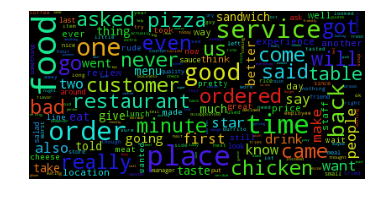

In [12]:
business_reviews = itertools.chain(*reviews.values())
business_reviews = filter(lambda x: x['rating'] <= 2.0, business_reviews)
all_bad_reviews = ' '.join([x['text'] for x in business_reviews])

wordcloud = WordCloud(max_font_size=40, relative_scaling=.5)
pic = wordcloud.generate(all_bad_reviews)
plt.imshow(pic)
plt.axis("off")
plt.show()